In [ ]:
Num!pip install neuralforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader
from numpy.random import seed
from random import randrange
from neuralforecast.losses.numpy import rmse, mape
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

In [ ]:
df = pd.read_excel("S&P 500 RV.xlsx",index_col='Date',parse_dates=True)

In [ ]:
df.reset_index(inplace=True)
df.rename(columns={'Date':'ds'}, inplace=True)
df.rename(columns={'RV':'y'}, inplace=True)
df.drop(columns=["wasserstein_dists_2D"], inplace=True)
df["unique_id"]="airplane1"
train = df.iloc[:int(len(df['y'])*0.8)]
test = df.iloc[int(len(df['y'])*0.8):]
validation_length=int(len(df['y'])*0.8)-int(len(df['y'])*0.6)

In [ ]:
n_inputs = [5,10,21,63,84,126,252]
mlp_units = [[[712, 712], [712, 712]],[[512, 512], [512, 512]],[[250, 250], [250, 250]],[[100, 100], [100, 100]]]
epochs=[25,50,100,150,250,350,450,550,750]
learning_rate=[0.0005,0.0001,0.00005,0.00001]
num_lr_decays=[5,3,2,1]
dropouts=[0,0.2,0.3,0.4,0.5]
scaler_type=["robust","standard",'minmax']
stack_types=[['identity','identity'],['trend','identity'],['seasonality','identity'],['trend','seasonality']]
n_harmonics=[0,0,1,1]
n_blocks=[[1, 1],[2, 2],[3, 3],[5, 5]]
n_polynomials=[0,1,0,1]
losses=[MSE(),MAE(),MQLoss(level=[90]),MQLoss(level=[80, 90]),MQLoss(level=[95]), MQLoss(level=[75])]


# Hyperparameter Search

In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 104329762


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 50503753


Epoch: 450 | Inputs: 252 | MLP units: [[250, 250], [250, 250]] | Loss: 2 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [1, 1]
RMSE: 0.002895754324120341 | QLIKE: 0.11542860232070816


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 34168783


Epoch: 250 | Inputs: 21 | MLP units: [[100, 100], [100, 100]] | Loss: 1 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001 | Block: [5, 5]
RMSE: 0.0024566968752892555 | QLIKE: 0.09003894793161273


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 62584796


Epoch: 150 | Inputs: 126 | MLP units: [[712, 712], [712, 712]] | Loss: 0 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 5e-05 | Block: [2, 2]
RMSE: 0.0025830997149796893 | QLIKE: 0.09751252393336836


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 119884690


Epoch: 100 | Inputs: 63 | MLP units: [[712, 712], [712, 712]] | Loss: 5 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005 | Block: [3, 3]
RMSE: 0.00245449375175844 | QLIKE: 0.0860575312269153


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 150 | Inputs: 5 | MLP units: [[250, 250], [250, 250]] | Loss: 4 | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 1e-05 | Block: [5, 5]
RMSE: 0.002608142772345875 | QLIKE: 0.10975938440330082


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 58933191


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 107589791


Epoch: 50 | Inputs: 21 | MLP units: [[100, 100], [100, 100]] | Loss: 3 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0005 | Block: [2, 2]
RMSE: 0.0028227653577175505 | QLIKE: 0.11784167315592492


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 48859060


Epoch: 25 | Inputs: 10 | MLP units: [[250, 250], [250, 250]] | Loss: 3 | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 5e-05 | Block: [2, 2]
RMSE: 0.0028039011950414237 | QLIKE: 0.11586980881952058


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 95275440


Epoch: 450 | Inputs: 10 | MLP units: [[512, 512], [512, 512]] | Loss: 0 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 5e-05 | Block: [3, 3]
RMSE: 0.002540995407084389 | QLIKE: 0.09013117324796101


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 29256018


Epoch: 450 | Inputs: 252 | MLP units: [[250, 250], [250, 250]] | Loss: 4 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 5e-05 | Block: [3, 3]
RMSE: 0.002716058141385785 | QLIKE: 0.11299827757172796


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 25 | Inputs: 252 | MLP units: [[512, 512], [512, 512]] | Loss: 4 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005 | Block: [1, 1]
RMSE: 0.0028947571819092827 | QLIKE: 0.1310493082197846


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 62350150


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 58496519


Epoch: 750 | Inputs: 10 | MLP units: [[100, 100], [100, 100]] | Loss: 0 | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 5e-05 | Block: [2, 2]
RMSE: 0.0024786277150163597 | QLIKE: 0.0874519989950908


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 90995300


Epoch: 350 | Inputs: 21 | MLP units: [[100, 100], [100, 100]] | Loss: 5 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 5e-05 | Block: [3, 3]
RMSE: 0.0025578613199419217 | QLIKE: 0.09792102195959071


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 55502398


Epoch: 750 | Inputs: 5 | MLP units: [[100, 100], [100, 100]] | Loss: 4 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 1e-05 | Block: [1, 1]
RMSE: 0.0027599829494251178 | QLIKE: 0.11602750353145064


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 101595575


Epoch: 550 | Inputs: 63 | MLP units: [[250, 250], [250, 250]] | Loss: 0 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0005 | Block: [2, 2]
RMSE: 0.0025597060497101315 | QLIKE: 0.0929449031184491


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 450 | Inputs: 21 | MLP units: [[100, 100], [100, 100]] | Loss: 1 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0005 | Block: [5, 5]
RMSE: 0.0025209796121957112 | QLIKE: 0.09144731930925938


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 126160510


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 108967979


Epoch: 350 | Inputs: 63 | MLP units: [[712, 712], [712, 712]] | Loss: 0 | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [3, 3]
RMSE: 0.0024561869353660892 | QLIKE: 0.08816911685106979


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 96846184


Epoch: 150 | Inputs: 252 | MLP units: [[250, 250], [250, 250]] | Loss: 5 | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0005 | Block: [2, 2]
RMSE: 0.0026221247455846318 | QLIKE: 0.10906800880805395


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 91233559


Epoch: 250 | Inputs: 126 | MLP units: [[100, 100], [100, 100]] | Loss: 5 | Scaler Type: standard
Stack Types: ['seasonality', 'identity'] | Learning Rate: 1e-05 | Block: [3, 3]
RMSE: 0.0029233945020634 | QLIKE: 0.15370568819056965


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 103766288


Epoch: 100 | Inputs: 84 | MLP units: [[512, 512], [512, 512]] | Loss: 4 | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [3, 3]
RMSE: 0.002869018688220858 | QLIKE: 0.12178172865612993


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 150 | Inputs: 63 | MLP units: [[512, 512], [512, 512]] | Loss: 1 | Scaler Type: minmax
Stack Types: ['trend', 'identity'] | Learning Rate: 0.0005 | Block: [5, 5]
RMSE: 0.0024848015786989907 | QLIKE: 0.08845046039878872


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 83025235


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 9217865


Epoch: 25 | Inputs: 10 | MLP units: [[712, 712], [712, 712]] | Loss: 4 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0005 | Block: [3, 3]
RMSE: 0.002566701259602227 | QLIKE: 0.09331681167654818


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 24792032


Epoch: 350 | Inputs: 84 | MLP units: [[512, 512], [512, 512]] | Loss: 3 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 5e-05 | Block: [5, 5]
RMSE: 0.002493538589144052 | QLIKE: 0.09019504053337025


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 45863585


Epoch: 750 | Inputs: 126 | MLP units: [[250, 250], [250, 250]] | Loss: 4 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 1e-05 | Block: [3, 3]
RMSE: 0.002736800896233739 | QLIKE: 0.10775046099609882


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 110461751


Epoch: 550 | Inputs: 10 | MLP units: [[100, 100], [100, 100]] | Loss: 5 | Scaler Type: robust
Stack Types: ['identity', 'identity'] | Learning Rate: 5e-05 | Block: [3, 3]
RMSE: 0.0025255013323113606 | QLIKE: 0.09526506625504716


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 25 | Inputs: 21 | MLP units: [[100, 100], [100, 100]] | Loss: 5 | Scaler Type: standard
Stack Types: ['trend', 'identity'] | Learning Rate: 5e-05 | Block: [5, 5]
RMSE: 0.0028925060238550616 | QLIKE: 0.12157435606403821


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 95602847


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 68322214


Epoch: 750 | Inputs: 5 | MLP units: [[512, 512], [512, 512]] | Loss: 5 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 1e-05 | Block: [5, 5]
RMSE: 0.0025365440472501877 | QLIKE: 0.0965732482714374


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 12372670


Epoch: 350 | Inputs: 21 | MLP units: [[250, 250], [250, 250]] | Loss: 2 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001 | Block: [3, 3]
RMSE: 0.002485551798920985 | QLIKE: 0.09084209859295674


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 76524804


Epoch: 100 | Inputs: 5 | MLP units: [[712, 712], [712, 712]] | Loss: 0 | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001 | Block: [2, 2]
RMSE: 0.0025677395225305456 | QLIKE: 0.09103830727885097


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 99516327


Epoch: 150 | Inputs: 126 | MLP units: [[250, 250], [250, 250]] | Loss: 2 | Scaler Type: robust
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0001 | Block: [5, 5]
RMSE: 0.0026285425481892295 | QLIKE: 0.1045135251993938


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 25 | Inputs: 5 | MLP units: [[512, 512], [512, 512]] | Loss: 2 | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 1e-05 | Block: [5, 5]
RMSE: 0.0028620855502365012 | QLIKE: 0.11809644090826635


In [ ]:
for m in range (5):
  i=randrange(7)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 109785192


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 73138082


Epoch: 450 | Inputs: 126 | MLP units: [[712, 712], [712, 712]] | Loss: 3 | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0005 | Block: [1, 1]
RMSE: 0.0026152173022023204 | QLIKE: 0.09768803911495008


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 124310447


Epoch: 250 | Inputs: 10 | MLP units: [[100, 100], [100, 100]] | Loss: 1 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0005 | Block: [3, 3]
RMSE: 0.0025386291404021137 | QLIKE: 0.09302206725453793


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 90213746


Epoch: 50 | Inputs: 252 | MLP units: [[512, 512], [512, 512]] | Loss: 5 | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 1e-05 | Block: [5, 5]
RMSE: 0.002894019897374319 | QLIKE: 0.12338595142268785


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 27626204


Epoch: 450 | Inputs: 252 | MLP units: [[512, 512], [512, 512]] | Loss: 4 | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001 | Block: [5, 5]
RMSE: 0.002629060968413889 | QLIKE: 0.10322154020001642


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 100 | Inputs: 21 | MLP units: [[512, 512], [512, 512]] | Loss: 4 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001 | Block: [2, 2]
RMSE: 0.0024531737615574333 | QLIKE: 0.08797015526002572


In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 4070484


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 61778997


Epoch: 550 | Inputs: 21 | MLP units: [[712, 712], [712, 712]] | Loss: 5 | Scaler Type: minmax
Stack Types: ['identity', 'identity'] | Learning Rate: 0.0001 | Block: [1, 1]
RMSE: 0.002480129234064695 | QLIKE: 0.08887915744583512


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 109467459


Epoch: 750 | Inputs: 10 | MLP units: [[712, 712], [712, 712]] | Loss: 4 | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 5e-05 | Block: [2, 2]
RMSE: 0.0026800440167845537 | QLIKE: 0.10200018374557762


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 118780232


Epoch: 50 | Inputs: 84 | MLP units: [[250, 250], [250, 250]] | Loss: 4 | Scaler Type: robust
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001 | Block: [5, 5]
RMSE: 0.002837178278980063 | QLIKE: 0.12102450355248238


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 4924261


Epoch: 50 | Inputs: 63 | MLP units: [[512, 512], [512, 512]] | Loss: 0 | Scaler Type: minmax
Stack Types: ['trend', 'seasonality'] | Learning Rate: 1e-05 | Block: [2, 2]
RMSE: 0.0029039687777188327 | QLIKE: 0.10628211499267749


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 550 | Inputs: 5 | MLP units: [[100, 100], [100, 100]] | Loss: 5 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 5e-05 | Block: [3, 3]
RMSE: 0.0025109577220479885 | QLIKE: 0.09420555613832493


In [ ]:
for m in range (5):
  i=randrange(6)
  h=randrange(4)
  a=randrange(4)
  k=randrange(9)
  l=randrange(4)
  m=randrange(6)
  n=randrange(4)
  o=randrange(3)
  model = NBEATSx(h=5, input_size=n_inputs[i],
                loss=losses[m],
                scaler_type=scaler_type[o],
                learning_rate=learning_rate[n],
                stack_types=stack_types[l],
                n_blocks=n_blocks[a],
                mlp_units=mlp_units[h],
                windows_batch_size=64,
                num_lr_decays=num_lr_decays[n],
                val_check_steps=500,
                n_harmonics=n_harmonics[l], n_polynomials=n_polynomials[l],
                hist_exog_list=['VIX'],
                max_steps=epochs[k],
                random_seed=randrange(129228148))
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Epoch: {epochs[k]} | Inputs: {n_inputs[i]} | MLP units: {mlp_units[h]} | Loss: {m} | Scaler Type: {scaler_type[o]}")
  print(f"Stack Types: {stack_types[l]} | Learning Rate: {learning_rate[n]} | Block: {n_blocks[a]}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 87409413


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 43522266


Epoch: 50 | Inputs: 10 | MLP units: [[512, 512], [512, 512]] | Loss: 2 | Scaler Type: robust
Stack Types: ['trend', 'identity'] | Learning Rate: 1e-05 | Block: [1, 1]
RMSE: 0.0028676254693778365 | QLIKE: 0.11424456710440252


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 113526493


Epoch: 100 | Inputs: 10 | MLP units: [[512, 512], [512, 512]] | Loss: 4 | Scaler Type: standard
Stack Types: ['identity', 'identity'] | Learning Rate: 1e-05 | Block: [2, 2]
RMSE: 0.002761993884299119 | QLIKE: 0.1110952843349227


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 116264427


Epoch: 25 | Inputs: 84 | MLP units: [[100, 100], [100, 100]] | Loss: 2 | Scaler Type: standard
Stack Types: ['trend', 'seasonality'] | Learning Rate: 0.0001 | Block: [1, 1]
RMSE: 0.0029238963035486017 | QLIKE: 0.11728413930716854


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 6521179


Epoch: 250 | Inputs: 63 | MLP units: [[712, 712], [712, 712]] | Loss: 2 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001 | Block: [2, 2]
RMSE: 0.0024438469347577998 | QLIKE: 0.0861405557358184


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Epoch: 25 | Inputs: 10 | MLP units: [[512, 512], [512, 512]] | Loss: 1 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001 | Block: [1, 1]
RMSE: 0.002588180303184303 | QLIKE: 0.10236571786433951


116264427

Epoch: 250 | Inputs: 63 | MLP units: [[712, 712], [712, 712]] | Loss: 2 | Scaler Type: minmax
Stack Types: ['seasonality', 'identity'] | Learning Rate: 0.0001 | Block: [2, 2]
RMSE: 0.0024438469347577998 | QLIKE: 0.0861405557358184


In [ ]:
for m in range (5):
  random_seed=randrange(129228148)
  model = NBEATSx(h=5, input_size=63,
                loss=losses[2],
                scaler_type='minmax',
                learning_rate= 0.0001,
                stack_types=['seasonality','identity'],
                n_blocks=[2,2],
                mlp_units= [[712, 712], [712, 712]],
                windows_batch_size=60,
                num_lr_decays=3,
                val_check_steps=100,
                n_harmonics=1, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=250,
                early_stop_patience_steps=1,
                random_seed=random_seed)
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Seed: {random_seed}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 29664567


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 67671771


Seed: 29664567
RMSE: 0.002491985476311559 | QLIKE: 0.0900338936728087


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 20491956


Seed: 67671771
RMSE: 0.0024310700335190122 | QLIKE: 0.08459314836793067


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 28250379


Seed: 20491956
RMSE: 0.0024718556611477444 | QLIKE: 0.08590286825100882


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 5323406


Seed: 28250379
RMSE: 0.0024619511022040885 | QLIKE: 0.08663951793226513


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seed: 5323406
RMSE: 0.0024613778927878786 | QLIKE: 0.08626437160899347


In [ ]:
for m in range (5):
  random_seed=randrange(129228148)
  model = NBEATSx(h=5, input_size=63,
                loss=losses[2],
                scaler_type='minmax',
                learning_rate= 0.0001,
                stack_types=['seasonality','identity'],
                n_blocks=[2,2],
                mlp_units= [[712, 712], [712, 712]],
                windows_batch_size=60,
                num_lr_decays=3,
                val_check_steps=100,
                n_harmonics=1, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=250,
                early_stop_patience_steps=1,
                random_seed=random_seed)
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Seed: {random_seed}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 6533636


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 91616456


Seed: 6533636
RMSE: 0.0025027456839797242 | QLIKE: 0.09080140231089645


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 80923423


Seed: 91616456
RMSE: 0.0024698628046815104 | QLIKE: 0.0878658056699755


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 58644298


Seed: 80923423
RMSE: 0.002501709284375603 | QLIKE: 0.08691572699580323


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 16058310


Seed: 58644298
RMSE: 0.002447583211009225 | QLIKE: 0.0864557520898936


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seed: 16058310
RMSE: 0.002483501299177088 | QLIKE: 0.08722209113845247


In [ ]:
for m in range (5):
  random_seed=randrange(129228148)
  model = NBEATSx(h=5, input_size=63,
                loss=losses[2],
                scaler_type='minmax',
                learning_rate= 0.0001,
                stack_types=['seasonality','identity'],
                n_blocks=[2,2],
                mlp_units= [[712, 712], [712, 712]],
                windows_batch_size=60,
                num_lr_decays=3,
                val_check_steps=100,
                n_harmonics=1, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=250,
                early_stop_patience_steps=1,
                random_seed=random_seed)
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Seed: {random_seed}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 44000537


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 109105875


Seed: 44000537
RMSE: 0.0025091826076711265 | QLIKE: 0.08965700629110303


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 19242248


Seed: 109105875
RMSE: 0.0025237985784865194 | QLIKE: 0.09384301184335363


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 88274328


Seed: 19242248
RMSE: 0.0024902069726326 | QLIKE: 0.09204374435998428


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 34213746


Seed: 88274328
RMSE: 0.002482407216762307 | QLIKE: 0.08797583384601526


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seed: 34213746
RMSE: 0.0024780570772245966 | QLIKE: 0.08592126008430458


In [ ]:
for m in range (5):
  random_seed=randrange(129228148)
  model = NBEATSx(h=5, input_size=63,
                loss=losses[2],
                scaler_type='minmax',
                learning_rate= 0.0001,
                stack_types=['seasonality','identity'],
                n_blocks=[2,2],
                mlp_units= [[712, 712], [712, 712]],
                windows_batch_size=60,
                num_lr_decays=3,
                val_check_steps=100,
                n_harmonics=1, n_polynomials=0,
                hist_exog_list=['VIX'],
                max_steps=250,
                early_stop_patience_steps=1,
                random_seed=random_seed)
  fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
  forecasts = fcst.cross_validation(df=train,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=validation_length-validation_length%5,step_size=5)
  forecasts = forecasts.dropna()
  if "NBEATSx-median" not in list(forecasts.columns.values):
    Y_hat=forecasts["NBEATSx"].values
  else:
    Y_hat=forecasts["NBEATSx-median"].values
  Y_true=forecasts["y"].values
  RMSE=np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true))
  QLIKE=(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))
  print(f"Seed: {random_seed}")
  print(f"RMSE: {RMSE} | QLIKE: {QLIKE}")

INFO:lightning_fabric.utilities.seed:Global seed set to 51602708


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 25631418


Seed: 51602708
RMSE: 0.002470782452238496 | QLIKE: 0.08848864623064968


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 20550269


Seed: 25631418
RMSE: 0.002490465470090833 | QLIKE: 0.08892417193947678


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 74523422


Seed: 20550269
RMSE: 0.00245373482289438 | QLIKE: 0.08600833640449713


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

INFO:lightning_fabric.utilities.seed:Global seed set to 19406459


Seed: 74523422
RMSE: 0.0024655512692102967 | QLIKE: 0.0846008459293549


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Seed: 19406459
RMSE: 0.002458423968172957 | QLIKE: 0.08578561939729308


# H=5 Forecasts

In [ ]:
RMSE=[]
Quasilikelihood=[]

In [ ]:
test_length=len(df["y"])-int(len(df['y'])*0.8)

In [ ]:
model = NBEATSx(h=5, input_size=63,
              loss=losses[2],
              scaler_type='minmax',
              learning_rate= 0.0001,
              stack_types=['seasonality','identity'],
              n_blocks=[2,2],
              mlp_units= [[712, 712], [712, 712]],
              windows_batch_size=60,
              num_lr_decays=3,
              val_check_steps=100,
              n_harmonics=1, n_polynomials=0,
              hist_exog_list=['VIX'],
              max_steps=250,
              early_stop_patience_steps=1,
              random_seed=67671771)
fcst = NeuralForecast(models=[model],freq=CustomBusinessDay(calendar=USFederalHolidayCalendar()))
forecasts = fcst.cross_validation(df=df,val_size=5,static_df=AirPassengersStatic,n_windows=None, test_size=test_length-test_length%5,step_size=5)
forecasts = forecasts.dropna()
if "NBEATSx-median" not in list(forecasts.columns.values):
  Y_hat=forecasts["NBEATSx"].values
else:
  Y_hat=forecasts["NBEATSx-median"].values
Y_true=forecasts["y"].values
RMSE.append(np.sqrt(np.sum(((Y_true-Y_hat)**2))/len(Y_true)))
Quasilikelihood.append(np.sum(Y_true/Y_hat-np.log(Y_true/Y_hat)-1)/len(Y_true))

INFO:lightning_fabric.utilities.seed:Global seed set to 67671771


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [ ]:
print(f"RMSE: {round(np.mean(RMSE)*100,4)}%")
print(f"QLIKE: {round(np.mean(Quasilikelihood)*100,2)}%")

RMSE: 0.4723%
QLIKE: 9.81%


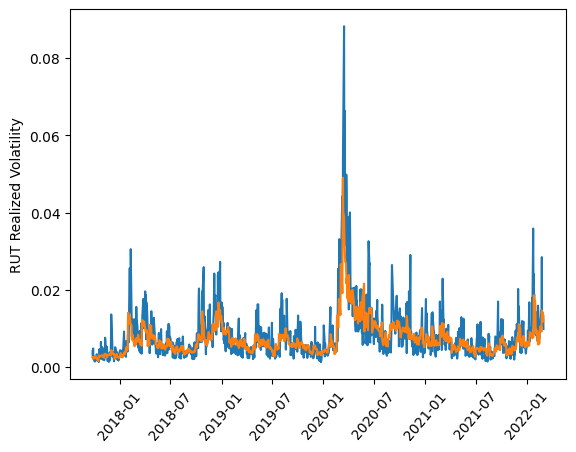

In [ ]:
plt.plot(forecasts["ds"], Y_true)
plt.plot(forecasts["ds"], Y_hat) 
plt.ylabel("S&P 500 Realized Volatility")
plt.xticks(rotation=50)
plt.show()

In [ ]:
Data = {'Date': forecasts["ds"],
        'Actuals': Y_true,
        'Forecast without PH': Y_hat
        }
df1=pd.DataFrame(data=Data)
df1.to_csv("Forecast without PH (NBEATSx).csv")